In [1]:
from paretoCardinalityRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
def findApproximateParetoSolutionsRestaurants(simMatrix, item_ids, sample_size=None, num_runs=10, k_max=50, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Objective vs Cardinality).
    Parameters:
    - simMatrix: Similarity matrix
    - item_ids: List of item ids (restaurants)
    - sample_size: Optional subsample size for items
    - num_runs: Number of independent runs
    - k_max: Maximum cardinality
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy-Cardinality", "TopK", "Random"]

    # Subsample items if requested
    n_items = len(item_ids)
    if sample_size is None or sample_size <= 0 or sample_size >= n_items:
        selected_indices = np.arange(n_items)
    else:
        rng = np.random.default_rng()
        selected_indices = rng.choice(n_items, size=sample_size, replace=False)
    selected_indices = np.sort(selected_indices)
    sub_items = [item_ids[i] for i in selected_indices]
    sub_sim = simMatrix[np.ix_(selected_indices, selected_indices)]

    # containers across runs
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_objectives = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # Pareto Greedy (Cardinality)
        pareto = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto.paretoGreedy()
        objectives = [pareto.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['ParetoGreedy-Cardinality'] = objectives
        run_runtimes['ParetoGreedy-Cardinality'] = runTime

        # Top K
        pareto2 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto2.top_k()
        objectives = [pareto2.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['TopK'] = objectives
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto3.random_selection()
        objectives = [pareto3.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['Random'] = objectives
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_objectives[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (num_runs, k_max)
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 0.5

    # Plot mean objective with shaded std band
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    markers = ['o', 's', '^', 'v', 'D']
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy-Cardinality"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'
        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-Cardinality":
            color = colors[3]
            marker = "D"
            zorder = 4
        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(range(1, k_max + 1), mean, label=label, color=color, linestyle=line_style, marker=marker, markersize=marker_size, markeredgewidth=1.1, markeredgecolor='k', linewidth=1.8, zorder=zorder)
        ax.fill_between(range(1, k_max + 1), np.clip(mean - std, 0, None), mean + std, color=color, alpha=0.18, zorder=2)
    
    ax.set_xlabel(r'Cardinality ($k$)', fontsize=28)
    ax.set_ylabel(r'Mean objective ($\bar{f}$)', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### Yelp Phoenix Experiments

In [3]:
#Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

2026-01-31 18:27:00,723 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-31 18:27:01,885 |INFO: Cardinality Greedy Solution:[179, 19, 144, 212, 247, 173, 44, 289, 238, 105, 122, 149, 126, 114, 175, 112, 251, 298, 141, 63, 160, 131, 48, 166, 106, 23, 108, 76, 51, 239, 217, 171, 201, 145, 88, 46, 234, 265, 209, 65, 282, 17, 151, 260, 0, 133, 135, 266, 174, 98], Objective:109.426, Runtime = 1.16 seconds
2026-01-31 18:27:01,886 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=50
2026-01-31 18:27:02,117 |INFO: Top-k Solution:[179, 234, 153, 88, 126, 71, 63, 49, 212, 39, 166, 257, 286, 58, 86, 10, 118, 93, 256, 116, 143, 64, 78, 40, 253, 218, 21, 19, 80, 164, 12, 192, 173, 62, 195, 69, 183, 144, 209, 210, 270, 105, 38, 147, 139, 110, 267, 102, 114, 186], Objective:84.395, Runtime = 0.23 seconds
2026-01-31 18:27:02,118 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num I

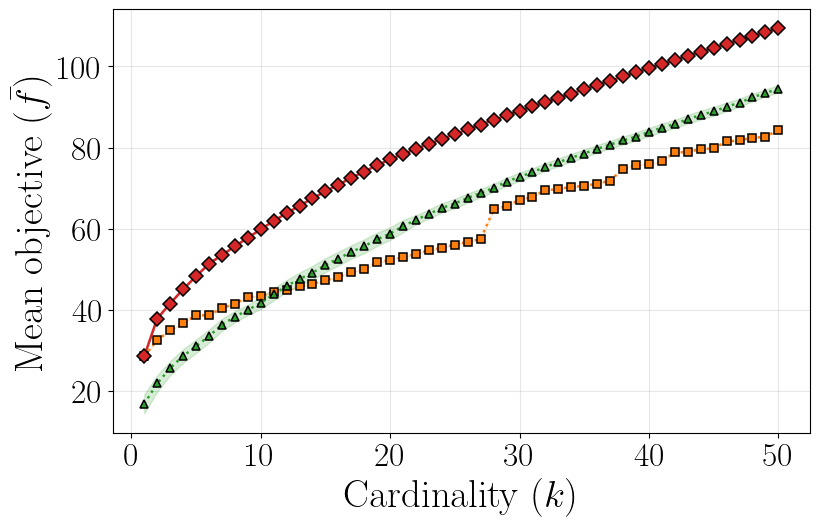

2026-01-31 18:27:25,196 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 1.208 ± 0.044
  - TopK: 0.234 ± 0.012
  - Random: 0.113 ± 0.007


In [4]:
# Adjust parameters as needed
sample_size = 300
num_runs = 15  # number of random runs
k_max = 50
findApproximateParetoSolutionsRestaurants(phoenix_simMatrix, phoenix_ids, sample_size, num_runs, k_max, "Yelp_Phoenix")

### Yelp Vegas Experiments

In [5]:
#Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

2026-01-31 18:27:25,254 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-31 18:27:28,518 |INFO: Cardinality Greedy Solution:[156, 67, 56, 258, 96, 88, 162, 103, 135, 164, 319, 491, 116, 413, 106, 281, 288, 377, 214, 50, 200, 61, 428, 22, 334, 400, 230, 170, 254, 82, 308, 229, 117, 129, 145, 359, 267, 204, 74, 270, 118, 153, 349, 255, 112, 85, 171, 460, 132, 344], Objective:158.306, Runtime = 3.26 seconds
2026-01-31 18:27:28,520 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:500, k_max=50
2026-01-31 18:27:28,942 |INFO: Top-k Solution:[156, 147, 200, 309, 164, 310, 180, 7, 319, 479, 3, 50, 367, 451, 151, 282, 152, 56, 74, 90, 79, 67, 294, 167, 376, 465, 258, 380, 71, 384, 397, 153, 374, 32, 390, 400, 165, 35, 416, 369, 11, 130, 275, 413, 242, 324, 34, 4, 177, 168], Objective:110.367, Runtime = 0.42 seconds
2026-01-31 18:27:28,943 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance

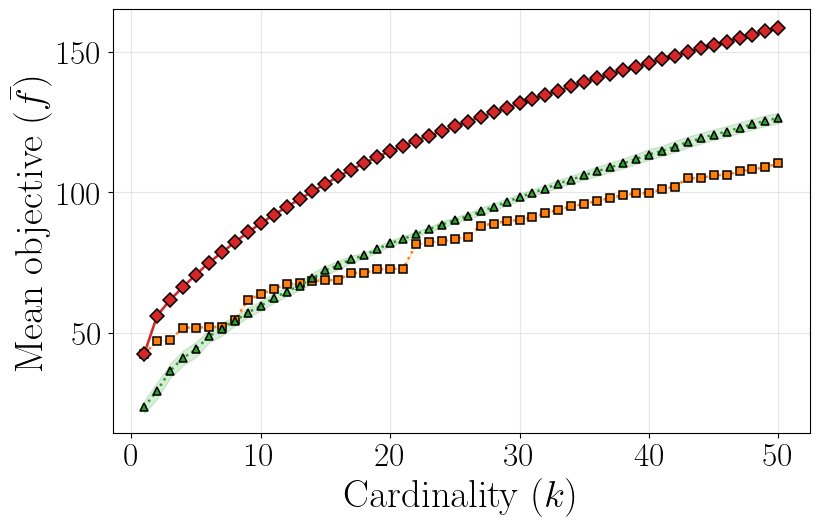

2026-01-31 18:28:23,886 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 3.271 ± 0.031
  - TopK: 0.423 ± 0.009
  - Random: 0.199 ± 0.009


In [6]:
# Adjust parameters as needed
sample_size = 500
num_runs = 15  # number of random runs
k_max = 50
findApproximateParetoSolutionsRestaurants(vegas_simMatrix, vegas_ids, sample_size, num_runs, k_max, "Yelp_Vegas")